In [1]:
#### ATOC7500 Lecture #3 - wilks_field_test_cartopy
#### Coded by Jen Kay (CU), Elizabeth Maroon (U.Wisc.), Eleanor Middelmas (CU), Elizabeth Barnes (CSU)
#### Last Updated: September 9, 2020
#### Note: Make sure you are using a python environment that includes h5py package.
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio
import h5py
import pickle
import pandas as pd  # library for data analysis for text files (everything but netcdf files)
%matplotlib inline
import cartopy.crs as ccrs ## mapping package, use because Basemap will go away

In [2]:
## Read in the munged data.  
pickled=1  ## set to 1 to use pickled data (default)

if pickled == 1:
    X = pickle.load( open( "TKE.p", "rb" ) )
    LAT = pickle.load( open( "LAT.p", "rb" ) )
    LONG = pickle.load( open( "LONG.p", "rb" ) )
if pickled == 0:
    ## Data format from Libby Barnes is a Matlab .mat file which is actually an hdf5.
    ## Data are Eddy Kinetic Energy (EKE, (m2/s2) from ERA-Interim Renalaysis
    DATA = h5py.File('era_interim_eke_nh.mat')
    X = np.array(DATA['EKE'])
    X = np.swapaxes(X,2,0)
    LAT = np.array(DATA['LAT'])[0,:]
    LONG = np.array(DATA['LONG'])[0,:]
    ### Fix data so there is no gap at 360E.  Final munged data data matrix "X".
    X = np.insert(X, 0, values=X[:,:,0], axis=2)
    LONG = np.insert(LONG,0,values = 0.)
    X = np.insert(X, -1, values=X[:,:,-1], axis=2)
    LONG = np.insert(LONG,-1,values = LONG[-1])
    LONG[-1] = 360
    del DATA
    ## Select January days only (992 January days from 32 Januaries)
    itime = []
    for j in np.arange(0,32,1):
        m = np.arange(j*365,j*365+31,1)
        itime = np.append(itime,m)
    X = X[np.ndarray.astype(itime,int),:,:]
    ## Pickle the data following https://wiki.python.org/moin/UsingPickle
    pickle.dump( X, open( "TKE.p", "wb" ) )
    pickle.dump( LAT, open( "LAT.p", "wb" ) )
    pickle.dump( LONG, open( "LONG.p", "wb" ) )

sizeX=np.shape(X)
print('Number of Januaries:',sizeX[0]/31)
print('Number of January Days:',sizeX[0])

Number of Januaries: 32.0
Number of January Days: 992


In [3]:
## Create two random subsets. Pick N random January days for each of the subsets.
## Then compare the two random subsets. 
## Note: Because the selected days are random, we don't expect any correlation necessarily...
## but maybe there are some correlations that will appear because EKE in January does preferentially occur
## in select locations?  Hmmm... worth thinking about...
## Null hypothesis = Subset #1 N random January days uncorrelated with Subset #2 X random January days

### Get our random January days
N = 2  ## Try N=1, N=2, N=5, N=30
Xmean = np.nanmean(X,axis=0)  ##nanmean = take average where original value is not NaN
sigma = np.nanstd(X,axis=0)
irand1 = np.random.randint(0,X.shape[0],N)
Xsubset1 = np.nanmean(X[irand1,:,:],axis = 0)
irand2 = np.random.randint(0,X.shape[0],N)
Xsubset2 = np.nanmean(X[irand2,:,:],axis = 0)

## Find the p-value to test null hypothesis locally and independently at each grid point
## note: could add in matrix version to avoid the forloop -- this would make it faster :).
P = np.empty((X.shape[1],X.shape[2]))
for ilat,vallat in enumerate(LAT):
    for ilon,vallon in enumerate(LONG):        
        zscore = (Xsubset1[ilat,ilon] - Xsubset2[ilat,ilon])/(sigma[ilat,ilon]/np.sqrt(N)) ## Chapter 1, Eq. 89 Barnes
        P[ilat,ilon] = stats.norm.sf(np.abs(zscore))*2.

/opt/anaconda3/envs/culabenv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1665: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/opt/anaconda3/envs/culabenv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


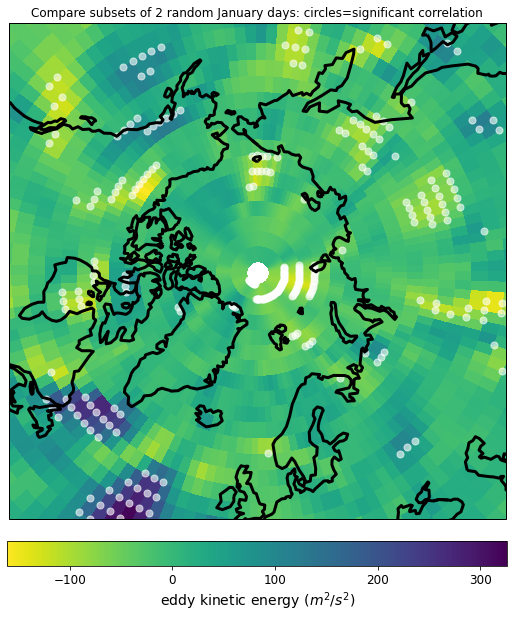

In [4]:
### Make a map of the difference of the subsets (subset1-subset2)
### Assess statistical significance on the map using local significance testing.
### Plot shows statistical significance but there is no physical meaning behind them
### because the N January days were selected randomly.
### Plot shows when statistics get you in trouble...

f=plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Stereographic(central_latitude=90,central_longitude=0)) 
cs=plt.pcolor(LONG,LAT,Xsubset1-Xsubset2,transform=ccrs.PlateCarree(),cmap=plt.cm.viridis_r) 
ax.coastlines(linewidth=3)
ax.set_extent([-180,180,50,90],crs=ccrs.PlateCarree()) 

### Add a marker if the pvalue indicates significance at the X% level
ptest=0.05 ##pvalue for local significance testing, set to 0.01 for 99% signifance, 0.05 for 95% significance
for ilat,vallat in enumerate(LAT):
    for ilon,vallon in enumerate(LONG):
        if(P[ilat,ilon]<ptest):
            plt.scatter(vallon,vallat,transform=ccrs.PlateCarree(),s=50, color = 'white',alpha=0.6)

cb = plt.colorbar(cs,orientation='horizontal',fraction=0.046, pad=0.04);
cb.set_label(label = 'eddy kinetic energy ($m^2/s^2$)', size = 14);
cb.ax.tick_params(labelsize=12);
plt.clim(-60,60);
plt.title('Compare subsets of ' + str(N) + ' random January days: circles=significant correlation');

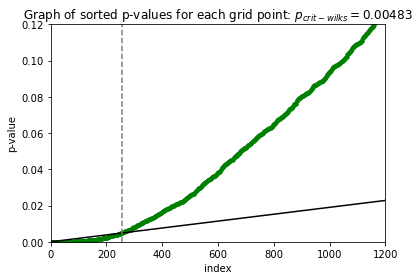

In [5]:
## Follow Wilks (2016) for field significance testing
##(Does it matter? We shall see or On va voir as the French would say...)

## Sort the pvalues (use data from all grid points)
Pvals = P.flatten()  ## turn it into a 1d vector
Pvals = np.sort(Pvals)  ## sort by Pvalue
x = np.arange(1,len(Pvals)+1,1)
x = x.astype(float)

### Plot the sorted pvalues
plt.plot(x,Pvals,'.g', markersize = 6, linewidth = 1.5)

alpha_fdr = ptest*2  ## alpha false detection rate; not a pvalue, chosen control level for false detection rate
#guidance from Wilks is to set alpha_fdr to 2 times global alpha (p-value).
#e.g., alpha_fdr=0.10 for global p-value 0.05 or 95% confidence
#e.g., alpha_fdr=0.02 for global p-value 0.01 or 99% confidence
y = (x/len(x))*alpha_fdr
plt.plot(x,y,'-',color = 'black', linewidth = 1.5)
plt.xlim(0,1200)
plt.ylim(0,.12)
plt.xlabel('index')
plt.ylabel('p-value')

## plot a gray vertical line where Pvals exceeds y to find pcrit_wilks
## pcrit_wilks is the p-value required for rejecting local null hypothesis.
d = Pvals - y
k = np.where(d>0)[0][0]  ### select first index using where d>0
plt.plot([k,k],[0,1],'--',color = 'gray');
pcrit_wilks=Pvals[k-1];
plt.title('Graph of sorted p-values for each grid point: $p_{crit-wilks} = $' + str(round(pcrit_wilks,6)));

/opt/anaconda3/envs/culabenv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1665: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/opt/anaconda3/envs/culabenv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


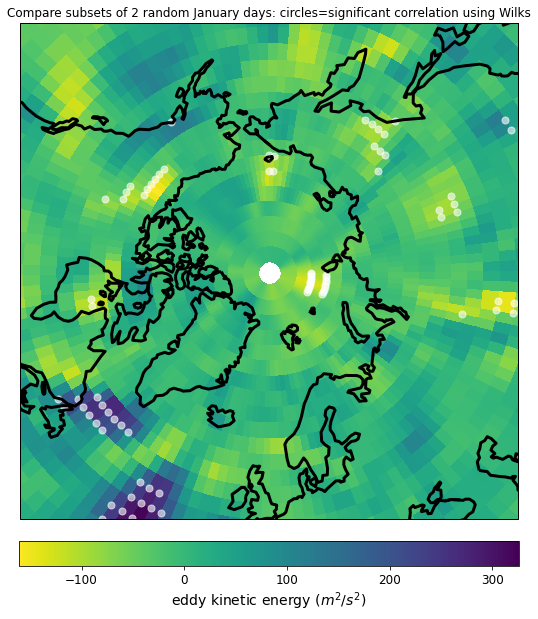

In [6]:
#### Make a map of the difference
#### Assess statistical significance on the map using Wilks2016 significance test 

f=plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Stereographic(central_latitude=90,central_longitude=0)) 
cs=plt.pcolor(LONG,LAT,Xsubset1-Xsubset2,transform=ccrs.PlateCarree(),cmap=plt.cm.viridis_r) 
ax.coastlines(linewidth=3)
ax.set_extent([-180,180,50,90],crs=ccrs.PlateCarree()) 

### if the pvalue indicates significance -- add a marker (which unfortunately covers up what you are looking at)
for ilat,vallat in enumerate(LAT):
    for ilon,vallon in enumerate(LONG):
        if(P[ilat,ilon]<pcrit_wilks):
            plt.scatter(vallon,vallat,transform=ccrs.PlateCarree(),s=50, color = 'white',alpha=0.6)
            
cb = plt.colorbar(cs,orientation='horizontal',fraction=0.046, pad=0.04)
cb.set_label(label = 'eddy kinetic energy ($m^2/s^2$)', size = 14);
cb.ax.tick_params(labelsize=12);
plt.clim(-60,60);
plt.title('Compare subsets of ' + str(N) + ' random January days: circles=significant correlation using Wilks');
